In [45]:
import pandas as pd
import json
import numpy as np
from pathlib import Path
import jsonlines
import matplotlib.pyplot as plt
import seaborn as sns


In [46]:
# Define directories
DATA_DIR = Path('/home/abdellah-ennajari/Desktop/AI-Powered-Academic-Research-Assistant')
RAW_DIR = DATA_DIR / 'Data/raw'
PROCESSED_DIR = DATA_DIR / 'Data/processed'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

In [47]:
# Load papers data
with open(RAW_DIR / 'id2paper.json', 'r') as f:
    papers = json.load(f)

In [48]:
# Convert papers to DataFrame
papers_df = pd.DataFrame(list(papers.items()), columns=['paper_id', 'title'])


In [49]:
# Drop duplicates and clean titles
papers_df = papers_df.drop_duplicates(subset='paper_id')
papers_df['title'] = papers_df['title'].fillna('').str.strip()


In [50]:
# Print dataset statistics
print("\nDataset Statistics:")
print(f"Number of papers: {len(papers_df)}")

# Show sample data
print("\nSample Papers Data:")
print(papers_df.head())

# Summary statistics
print("\nPapers DataFrame Info:")
print(papers_df.info())

print("\nPapers DataFrame Description:")
print(papers_df.describe())



Dataset Statistics:
Number of papers: 569432

Sample Papers Data:
     paper_id                                              title
0  2404.00001  Uso de herramientas digitales matem\'aticas en...
1  2404.00006  A Critique of Chen's "The 2-MAXSAT Problem Can...
2  2404.00007  A Comprehensive Tutorial on over 100 Years of ...
3  2404.00009  Applying Cognitive Diagnostic Models to Mechan...
4  2404.00012  Stress index strategy enhanced with financial ...

Papers DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569432 entries, 0 to 569431
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   paper_id  569432 non-null  object
 1   title     569432 non-null  object
dtypes: object(2)
memory usage: 8.7+ MB
None

Papers DataFrame Description:
         paper_id           title
count      569432          569432
unique     569432          556424
top     1009.4409  1 Introduction
freq            1            5748


# ====================================================
# Feature Engineering
# ====================================================


In [51]:
# 1. Add title length as a feature
papers_df['title_length'] = papers_df['title'].apply(len)


In [52]:
# 2. Add word count as a feature
papers_df['word_count'] = papers_df['title'].apply(lambda x: len(x.split()))


In [53]:
# 3. Add presence of specific keywords (e.g., "machine learning")
papers_df['contains_ml'] = papers_df['title'].str.contains('machine learning', case=False, regex=False).astype(int)

In [54]:
# 4. Add year of publication (if available in the data)
# Extract year only for paper_ids that start with 4 digits
papers_df['year'] = papers_df['paper_id'].str.extract(r'^(\d{4})')[0]  # Extract first 4 digits
papers_df['year'] = papers_df['year'].astype(float)  # Convert to float (NaN for invalid values)


In [55]:
# Print the number of papers with valid years
valid_years = papers_df['year'].notna()
print(f"\nNumber of papers with valid years: {valid_years.sum()}")



Number of papers with valid years: 563499


# ====================================================
# Handling Missing Values
# ====================================================


In [56]:
# Check for missing values
print("\nMissing Values in Papers Data:")
print(papers_df.isnull().sum())



Missing Values in Papers Data:
paper_id           0
title              0
title_length       0
word_count         0
contains_ml        0
year            5933
dtype: int64


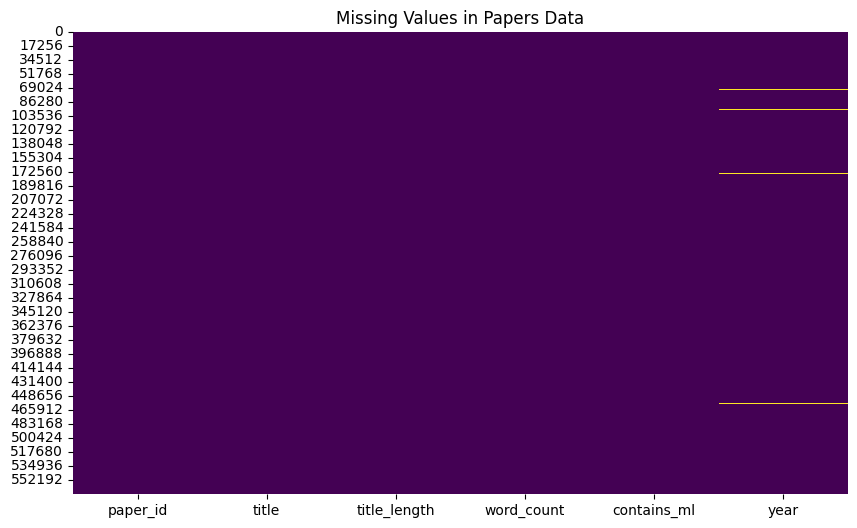

In [57]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(papers_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Papers Data')
plt.show()

In [58]:
# Fill missing years with the median year
if 'year' in papers_df.columns:
    median_year = papers_df['year'].median()
    papers_df['year'] = papers_df['year'].fillna(median_year)


# ====================================================
# Outlier Detection and Removal
# ====================================================


In [59]:
# Function to detect outliers using IQR
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column < lower_bound) | (column > upper_bound)]


In [60]:
# Detect and remove outliers in title length
title_length_outliers = detect_outliers(papers_df['title_length'])
print(f"\nOutliers in Title Length: {len(title_length_outliers)}")
papers_df = papers_df[~papers_df['title_length'].isin(title_length_outliers)]



Outliers in Title Length: 27473


In [61]:
# Detect and remove outliers in word count
word_count_outliers = detect_outliers(papers_df['word_count'])
print(f"Outliers in Word Count: {len(word_count_outliers)}")
papers_df = papers_df[~papers_df['word_count'].isin(word_count_outliers)]


Outliers in Word Count: 6045


# ====================================================
# Visualizations
# ====================================================


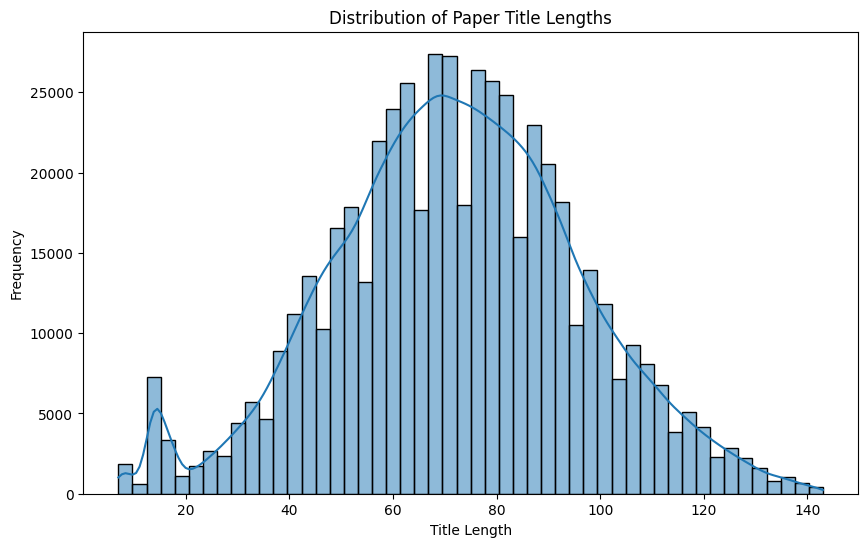

In [62]:
# 1. Distribution of paper titles length
plt.figure(figsize=(10, 6))
sns.histplot(papers_df['title_length'], bins=50, kde=True)
plt.title('Distribution of Paper Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.show()

In [63]:
# 2. Top 10 most common words in paper titles
from collections import Counter
import re

In [64]:
# Extract words from titles
words = []
for title in papers_df['title']:
    words.extend(re.findall(r'\b\w+\b', title.lower()))


In [65]:
# Count word frequencies
word_counts = Counter(words)
top_words = word_counts.most_common(10)


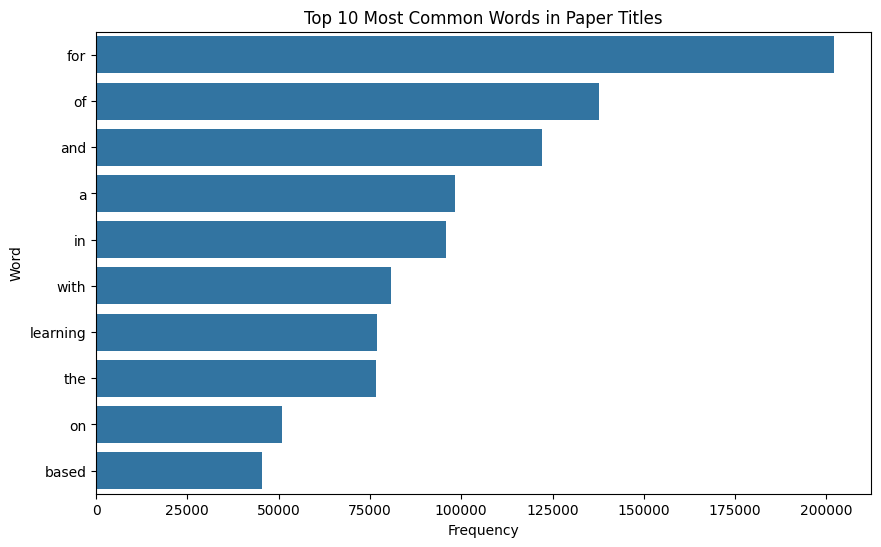

In [66]:
# Plot top words
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for word, count in top_words], y=[word for word, count in top_words])
plt.title('Top 10 Most Common Words in Paper Titles')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

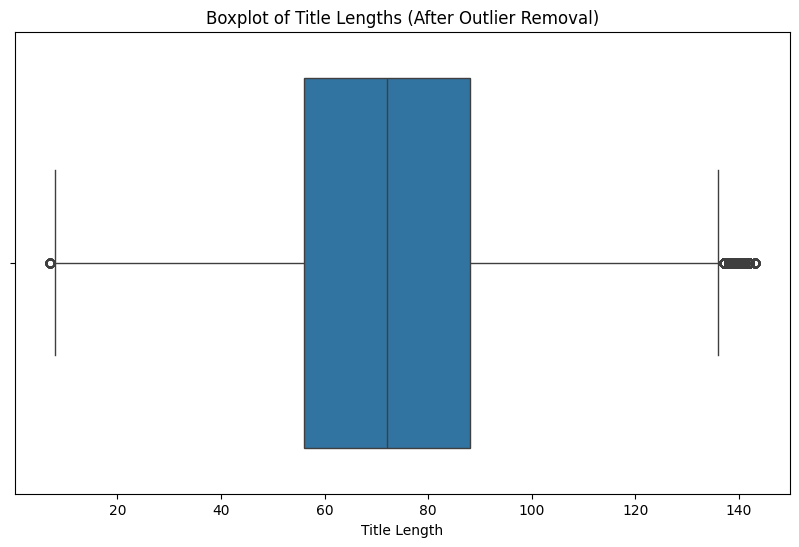

In [67]:
# 3. Boxplot of title lengths after outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(x=papers_df['title_length'])
plt.title('Boxplot of Title Lengths (After Outlier Removal)')
plt.xlabel('Title Length')
plt.show()

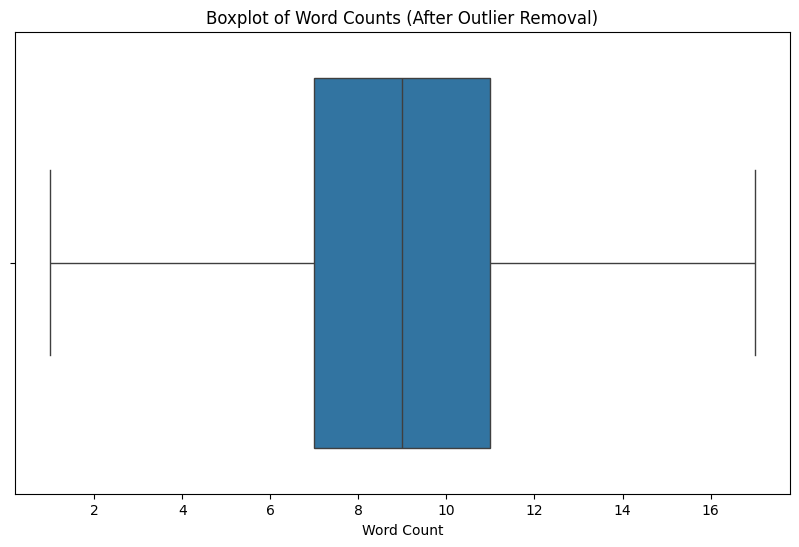

In [68]:
# 4. Boxplot of word counts after outlier removal
plt.figure(figsize=(10, 6))
sns.boxplot(x=papers_df['word_count'])
plt.title('Boxplot of Word Counts (After Outlier Removal)')
plt.xlabel('Word Count')
plt.show()

In [69]:
papers_df.to_csv(PROCESSED_DIR / 'cleaned_papers.csv', index=False)

print("\nData preprocessing completed and saved to 'processed' directory.")


Data preprocessing completed and saved to 'processed' directory.
